### Carregamento dos dados

In [1]:
import torch
import gc
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

from src.data import LOCCADataset  # noqa: E402, F401
from src.constants import BATCH_SIZE, NUM_FOLDS  # noqa: E402, F401
# from torchmetrics.segmentation import HausdorffDistance  # noqa: E402, F401

##### Transformações

In [2]:
import albumentations as A

# Veja: https://albumentations.ai/docs/3-basic-usage/semantic-segmentation/
# De acordo com isso, ao especificar os parametros image e mask para transform, 
# algumas transformações que só fazem sentido serem aplicadas em imagens não serão
# aplicadas nas máscaras.

# Talvez, devido o pré-procesamento, não faça sentido o uso de transformações de intensidades dos pixels
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
])


test_transform = A.Compose([
    # A.Normalize(mean=(0.5,), std=(0.5,)),
])

#### Instanciação do Dataset

In [3]:
import torch
from torch.utils.data import DataLoader

train_dataset = LOCCADataset(
    ROOT_DIR / 'datasets/locca/pngs_preprocessed/train',
    train_transform
)

val_dataset = LOCCADataset(
    ROOT_DIR / 'datasets/locca/pngs_preprocessed/test',
    test_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,  #TODO: isso pode atrapalhar a avaliação de desempenho? Imagino que sim!
    num_workers=8,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8
)


### Visualização

In [4]:
loader = iter(train_loader)

In [5]:
batch = next(loader)
print(batch['volume'].shape)

torch.Size([8, 512, 512])


In [6]:
import random


def visualize_batch_overlay(batch, n_samples=4, alpha=0.5):
    volume = batch["volume"]
    mask = batch["mask"]

    B = volume.shape[0]
    idxs = random.sample(range(B), min(n_samples, B))

    fig, axs = plt.subplots(len(idxs), 3, figsize=(6, 3 * len(idxs)))

    if len(idxs) == 1:
        axs = [axs]

    for lin, i in zip(axs, idxs):
        ct = volume[i].cpu().numpy()
        m = mask[i].cpu().numpy()

        lin[0].imshow(ct, cmap="gray")
        lin[0].set_title(f"slice [{i}]\nftype: {volume[i].cpu().dtype}")
        lin[0].axis("off")

        lin[1].imshow(m, cmap="Reds")
        lin[1].set_title(f"mask [{i}]\nvalues: {np.unique(m)}\ndtype: {mask[i].cpu().dtype}")
        lin[1].axis("off")

        lin[2].imshow(ct, cmap="gray")
        lin[2].imshow(m > 0, cmap="Reds", alpha=alpha)
        lin[2].set_title(f"Overlay slice [{i}]")
        lin[2].axis("off")

    plt.tight_layout()
    plt.show()

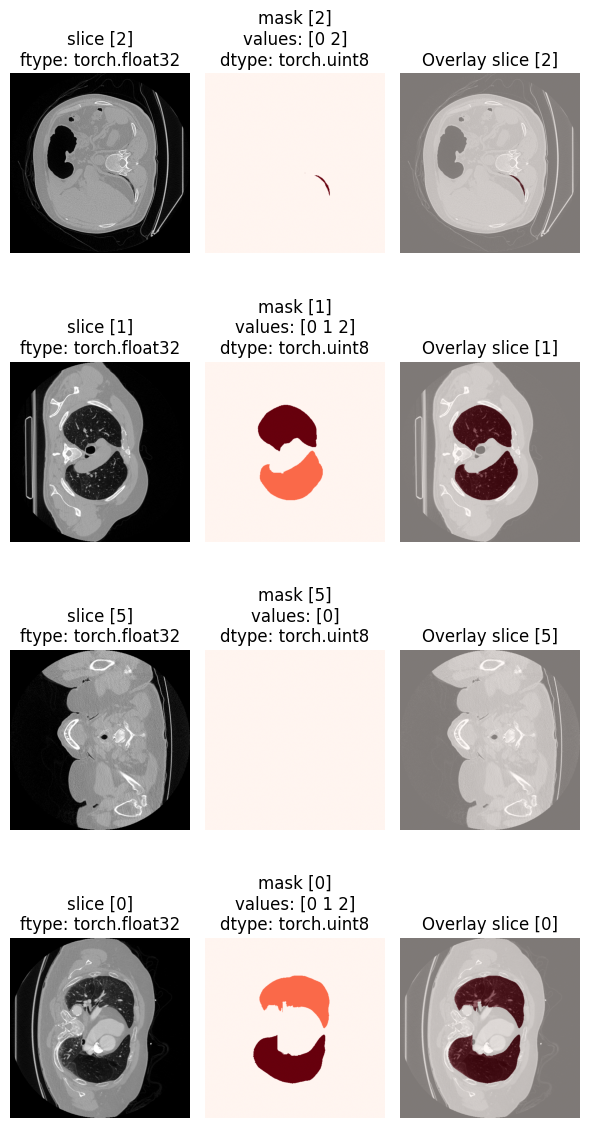

In [7]:
visualize_batch_overlay(batch)

### Linghting Module
Baseado em: https://colab.research.google.com/github/qubvel-org/segmentation_models.pytorch/blob/main/examples/camvid_segmentation_multiclass.ipynb

In [ ]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
# from torchmetrics.segmentation import HausdorffDistance


class LOCCAModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        self.number_of_classes = out_classes

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # self.hausdorff_metric = HausdorffDistance(num_classes=out_classes, input_format="index")  # Custo computacional enorme
        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        """ Esse é um bloco de código utilizado tanto no treinamento, quanto na
        validação e no teste. """
        image, mask = batch['volume'], batch['mask']
        print(image.shape)

        
        # Plot para DEBUG
        # img_i = image[3]
        # mask_i = mask[3]
        # plt.subplot(121); plt.imshow(img_i.cpu().permute(2, 1, 0)); 
        # plt.subplot(122); plt.imshow(mask_i.cpu().permute(1,0));
        # plt.show()

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, 1, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)
        print(logits_mask.shape)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)


        # Plot para DEBUG
        # img_i = image[3]
        # pred_mask_i = pred_mask[3]
        # plt.subplot(121); plt.imshow(img_i.cpu().permute(2, 1, 0)); plt.axis('off');
        # plt.subplot(122); plt.imshow(pred_mask_i.cpu().permute(1,0)); plt.axis('off');
        # plt.show()


        # Calculanto as quantidades de tp,fp,tn,fn que serão usadas como base para as métricas
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )
        metrics = self.compute_metrics(tp, fp, fn, tn, stage)
        self.log(f"step_loss_{stage}", loss, prog_bar=True, batch_size=BATCH_SIZE)
        self.log_dict({f"step_{k}_{stage}": v for k,v in metrics.items()}, prog_bar=True, batch_size=BATCH_SIZE)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        metrics = self.compute_metrics(tp, fp, fn, tn, stage)

        self.log_dict({f"epoch_{k}_{stage}": v for k,v in metrics.items()}, prog_bar=True, batch_size=BATCH_SIZE)

        avg_loss = torch.mean(torch.tensor([x["loss"].item() for x in outputs]))
        self.log(f"avg_loss_epoch_{stage}", avg_loss, batch_size=BATCH_SIZE)
        

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
 
    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        # Sem uso de Scheduler para que não haja mudança na evolução da Lr ao rodar outro modelo
        return {
            "optimizer": optimizer,
        }
    
    def compute_metrics(self, tp, fp, fn, tn, stage):
        # # Housdorff
        # hd = self.hausdorff_metric(pred_mask, mask)

        # IoU
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        # sensitivity
        per_image_sensitivity = smp.metrics.sensitivity(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_sensitivity = smp.metrics.sensitivity(tp, fp, fn, tn, reduction="micro")

        # specificity
        per_image_specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="micro")

        # f1-score
        per_image_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")


        return {
            # "hd": hd,

            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,

            f"{stage}_per_image_sensitivity": per_image_sensitivity,
            f"{stage}_dataset_sensitivity": dataset_sensitivity,
            
            f"{stage}_per_image_specificity": per_image_specificity,
            f"{stage}_dataset_specificity": dataset_specificity,

            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
        }

In [9]:
# 1. Delete as variáveis pesadas (modelo, otimizador, batches)
if 'model' in locals():
    del model
if 'batch' in locals():
    del batch

# 2. Força a coleta de lixo do Python
gc.collect()

# 3. Limpa o cache de memória da GPU
torch.cuda.empty_cache()

# Opcional: verifique quanta memória sobrou
print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Memória alocada: 0.00 MB


In [10]:
model = LOCCAModel("UnetPlusPlus", "mobilenet_v2", in_channels=1, out_classes=3)

In [ ]:
# torch.set_float32_matmul_precision('medium')

# trainer = pl.Trainer(max_epochs=3, log_every_n_steps=1)

# trainer.fit(
#     model,
#     train_dataloaders=train_loader,
# )

### Training

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)  # Shufle aqui apenas embaralha as folds e não as amostras em cada fold


dataset = ...  #TODO: Aqui, o conjunto de testes da divisão inicial será visto como um conjunto de validação externa
NUM_REPT = 3


for repet in range (NUM_REPT):
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('_'*80)
        
        # Escolha de elementos do conjunto de treino e teste, onde
        # os elementos são embaralhados
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        # Definição do carregador do conjunto de Treino e Teste com base nas folds
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=BATCH_SIZE, sampler=test_subsampler)
        
        # Treinamento do modelo utilizando Lighting Module
        # aqui irei armazenar todas as métricas resultantes com a informação
        # sobre qual iteração do Kfold e qual repetição para análise posteriormente
         
    